In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


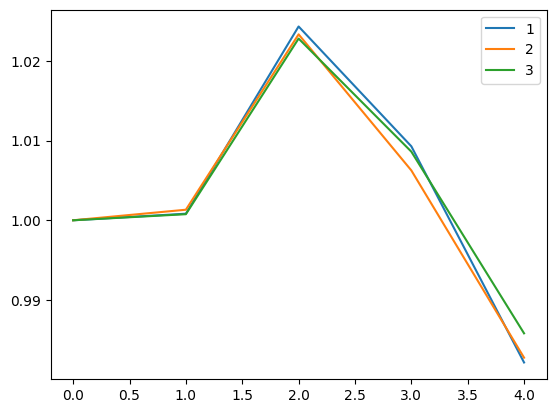

In [3]:
N_NEEDED = 6

perf1 = np.array([100673,100756,103122,101608, 98876])
perf2 = np.array([ 99670, 99802,101996,100294, 97951])
perf3 = np.array([ 99704, 99780,101978,100563, 98289])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 95421,102079,101704]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 1  # [1, 2, 3]
MUTATE_SCALE = 0.45  # x0.9 or x1.1

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,78.080002,1,0.095524,0.904476,0.068760,0.003763,0.632117
1,AAPL,217.899994,0,0.169864,0.830136,0.186804,0.094900,0.861549
2,ABNB,120.690002,0,0.093897,0.906103,0.085264,0.154974,0.156809
3,ACN,304.329987,0,0.015188,0.984812,0.070747,0.036789,0.661104
4,ADBE,385.709991,0,0.068745,0.931255,0.085851,0.043896,0.664382


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating..')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,1015.04,1015.04,0.00
AAPL,871.60,653.70,871.60
ABBV,615.87,615.87,821.16
ABT,523.28,0.00,0.00
ACN,912.99,912.99,912.99


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,78.08,0.005986,0.005683,0.005679
1,AAPL,217.90,0.006067,0.005702,0.005700
2,ABNB,120.69,0.005382,0.005561,0.005494
3,ACN,304.33,0.005999,0.005686,0.005654
4,ADBE,385.71,0.006008,0.005689,0.005665


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[197752.15000000002, 195901.97, 196578.93]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,78.08,0.005986,0.005683,0.005679,1183.66,1113.37,1116.46
AAPL,217.90,0.006067,0.005702,0.005700,1199.69,1117.05,1120.53
ABNB,120.69,0.005382,0.005561,0.005494,1064.32,1089.32,1080.08
ACN,304.33,0.005999,0.005686,0.005654,1186.24,1113.83,1111.53
ADBE,385.71,0.006008,0.005689,0.005665,1188.16,1114.49,1113.52


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,78.08,0.005986,0.005683,0.005679,1183.66,1113.37,1116.46,1015.04,1015.04,0.00
AAPL,217.90,0.006067,0.005702,0.005700,1199.69,1117.05,1120.53,871.60,653.70,871.60
ABNB,120.69,0.005382,0.005561,0.005494,1064.32,1089.32,1080.08,0.00,0.00,0.00
ACN,304.33,0.005999,0.005686,0.005654,1186.24,1113.83,1111.53,912.99,912.99,912.99
ADBE,385.71,0.006008,0.005689,0.005665,1188.16,1114.49,1113.52,1157.13,385.71,1157.13


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,78.08,0.005986,0.005683,0.005679,1183.66,1113.37,1116.46,1015.04,1015.04,0.00,168.62,98.33,1116.46
AAPL,217.90,0.006067,0.005702,0.005700,1199.69,1117.05,1120.53,871.60,653.70,871.60,328.09,463.35,248.93
ABNB,120.69,0.005382,0.005561,0.005494,1064.32,1089.32,1080.08,0.00,0.00,0.00,1064.32,1089.32,1080.08
ACN,304.33,0.005999,0.005686,0.005654,1186.24,1113.83,1111.53,912.99,912.99,912.99,273.25,200.84,198.54
ADBE,385.71,0.006008,0.005689,0.005665,1188.16,1114.49,1113.52,1157.13,385.71,1157.13,31.03,728.78,-43.61


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,78.08,0.005986,0.005683,0.005679,1183.66,1113.37,1116.46,1015.04,1015.04,0.00,168.62,98.33,1116.46,2,1,14
AAPL,217.90,0.006067,0.005702,0.005700,1199.69,1117.05,1120.53,871.60,653.70,871.60,328.09,463.35,248.93,2,2,1
ABNB,120.69,0.005382,0.005561,0.005494,1064.32,1089.32,1080.08,0.00,0.00,0.00,1064.32,1089.32,1080.08,9,9,9
ACN,304.33,0.005999,0.005686,0.005654,1186.24,1113.83,1111.53,912.99,912.99,912.99,273.25,200.84,198.54,1,1,1
ADBE,385.71,0.006008,0.005689,0.005665,1188.16,1114.49,1113.52,1157.13,385.71,1157.13,31.03,728.78,-43.61,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,8.68,0.003383,0.004735,0.005004,668.99,927.63,983.73,0.00,0.00,0.00,668.99,927.63,983.73,77,107,113
WING,224.00,0.005903,0.005679,0.005652,1167.40,1112.50,1111.16,896.00,896.00,896.00,271.40,216.50,215.16,1,1,1
WIT,3.03,0.003979,0.005186,0.005285,786.86,1015.88,1038.87,0.00,0.00,0.00,786.86,1015.88,1038.87,260,335,343


In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
NTDOY,17.94,1194.86,67
NXE,4.55,1190.33,262
CRM,269.97,1182.55,4
QSR,64.52,1181.54,18
PTC,154.80,1179.95,8


In [23]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
BYD,66.25,52.20,1
PEP,149.27,-121.75,-1
SIFY,4.39,-124.33,-28
AMT,215.56,-188.45,-1
VRTX,492.69,-282.50,-1


In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
NTDOY,17.94,1116.99,62
NXE,4.55,1114.85,245
QSR,64.52,1113.96,17
HLT,225.71,1113.76,5
RTX,131.72,1113.71,8


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
AAON,78.08,98.33,1
KKR,114.86,81.33,1
BAH,105.28,61.44,1
KR,66.72,36.74,1
SIFY,4.39,-61.61,-14


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
NTDOY,17.94,1120.50,62
QSR,64.52,1117.96,17
IVV,558.12,1117.36,2
AAON,78.08,1116.46,14
NXE,4.55,1114.05,245


In [28]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
MDT,87.63,61.01,1
IEFA,76.40,47.83,1
GDX,45.57,-29.22,-1
SIFY,4.39,-63.81,-15
BABA,132.43,-76.99,-1


In [29]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
